#### This is a demo for lithofacies classification using recurrent neural networks.
Specially, the gated recurrent units is applied.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras.layers import Input, GRU, concatenate, Dropout, Dense
from keras.optimizers import Nadam
from keras.models import Model
from keras.utils import np_utils

Using TensorFlow backend.


Import data (kappa_inv, M_inv, kappa_out, M_out, Lithos)

In [2]:
osdir = os.getcwd()
kappa_hc  = np.loadtxt('kappa_hc.dat')
M_hc      = np.loadtxt('M_hc.dat')
kappa_inv = np.loadtxt('kappa_inv.dat')
M_inv     = np.loadtxt('M_inv.dat')
kappa_out = np.loadtxt('kappa_out.dat')
M_out     = np.loadtxt('M_out.dat')
Lithos_hc = np.loadtxt('Lithos_hc.dat')
Lithos_out = np.loadtxt('Lithos_out.dat')

In [3]:
lithos = np.unique(Lithos_hc)
lithos_num = len(lithos)

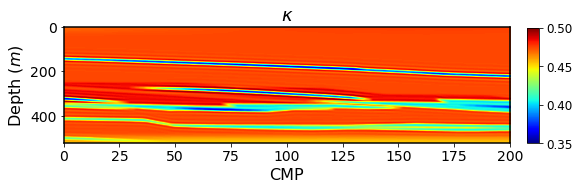

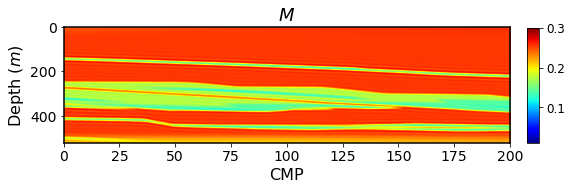

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))
#plt.plot([100,100], [0,520], '--k', lw = 2) # well location
im = ax.imshow(kappa_hc, cmap='jet', interpolation = 'bicubic', extent = [0, 200, 520, 0])
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.tick_params(labelsize = 14)
ax.set_aspect('0.1')
ax.set_xlabel("CMP", fontsize = 16)
ax.set_ylabel("Depth ($m$)", fontsize = 16)  
ax.set_title("$\kappa$", fontsize = 18)  
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cax = plt.axes([0.93, 0.3, 0.02, 0.4])
#cax.set_title('(×$10^{7}$)', fontsize = 12)
cbar = fig.colorbar(im, cax = cax)
cbar.ax.tick_params(labelsize=12) 
#v = np.linspace(-1, 1, 0.5, endpoint=True)
#plt.colorbar(ticks=v)
im.set_clim(vmin = 0.35, vmax = 0.5)  
#cbar.set_ticks([-0.8,-0.4,0.0,0.4,0.8])

fig, ax = plt.subplots(figsize=(8, 4))
#plt.plot([100,100], [0,520], '--k', lw = 2)  # well location
im = ax.imshow(M_hc, cmap='jet', interpolation = 'bicubic', extent = [0, 200, 520, 0])
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.tick_params(labelsize = 14)
ax.set_aspect('0.1')
ax.set_xlabel("CMP", fontsize = 16)
ax.set_ylabel("Depth ($m$)", fontsize = 16)  
ax.set_title("$M$", fontsize = 18)  
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cax = plt.axes([0.93, 0.3, 0.02, 0.4])
#cax.set_title('(×$10^{7}$)', fontsize = 12)
cbar = fig.colorbar(im, cax = cax)
cbar.ax.tick_params(labelsize=12) 
#v = np.linspace(-1, 1, 0.5, endpoint=True)
#plt.colorbar(ticks=v)
im.set_clim(vmin = 0.01, vmax = 0.3)  
#cbar.set_ticks([-0.8,-0.4,0.0,0.4,0.8])

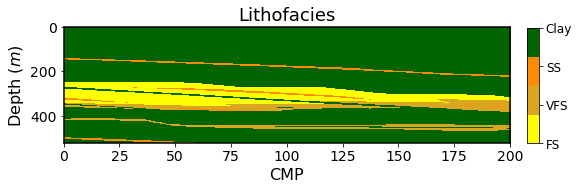

In [5]:
facies_colors = ['#FFFF00','#DAA520','#FF8C00','#006400']    
facies_labels = ['FS','VFS','SS','Clay']
cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')

fig, ax = plt.subplots(figsize=(8, 4))
#plt.plot([100,100], [0,520], '--k', lw = 2)  # well location
im = ax.imshow(Lithos_hc, cmap=cmap_facies,vmin=0,vmax=lithos_num-1, extent = [0, 200, 520, 0])
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.tick_params(labelsize = 14)
ax.set_aspect('0.1')
ax.set_xlabel("CMP", fontsize = 16)
ax.set_ylabel("Depth ($m$)", fontsize = 16)  
ax.set_title("Lithofacies", fontsize = 18)  
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cax = plt.axes([0.93, 0.3, 0.02, 0.4])
#cax.set_title('(×$10^{7}$)', fontsize = 12)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(facies_labels)


Now select the CMP location for the training of GRU

In [6]:
CMP_train = [100]
kappa_train = kappa_hc[:,CMP_train]
M_train = M_hc[:,CMP_train]
X_train_temp = np.hstack((kappa_train,M_train))

Y_train = Lithos_hc[:,CMP_train]
Y_train = np_utils.to_categorical(Y_train,lithos_num)

window_width = 2

from expand_dims import expand_dims

X_train = expand_dims(X_train_temp, window_width) 

Now define the GRU model

In [7]:
def gru_model():
    input_lstm=Input(shape=(conv_length,input_dim), name='Input')
    
    x_lstm_1=GRU(lstm_dim1, return_sequences=True, init='uniform', dropout_W=lstm_drop, dropout_U=lstm_drop, name='LSTM_1')(input_lstm)

    lstm_in_2=concatenate([input_lstm,x_lstm_1], axis = 2)
    x_lstm_2=GRU(lstm_dim2, init='uniform',dropout_W=lstm_drop, dropout_U=lstm_drop, name='LSTM_2')(lstm_in_2)

    x_dense=Dropout(dense_drop)(x_lstm_2)

    out_dense=Dense(lithos_num, activation='softmax', name='Output')(x_dense)

#define model
    model=Model(input=input_lstm, output=out_dense)

#optimizer and compile
    optimizerNadam = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    model.compile(loss='categorical_crossentropy', optimizer=optimizerNadam, metrics=['accuracy'])
    return model

In [ ]:
conv_length = window_width
input_dim = 2
lstm_dim1 = 10
lstm_dim2 = 10
lstm_drop = 0.1
dense_drop = 0.1

n_per_batch = 1300
epochs = 10000

model_gru = gru_model()
model_gru.summary()

model_gru.fit(X_train, Y_train, batch_size=n_per_batch, nb_epoch=epochs, verbose=1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/Users/Runhai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(10, return_sequences=True, name="LSTM_1", kernel_initializer="uniform", dropout=0.1, recurrent_dropout=0.1)`
  after removing the cwd from sys.path.
/Users/Runhai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(10, name="LSTM_2", kernel_initializer="uniform", dropout=0.1, recurrent_dropout=0.1)`
  import sys
/Users/Runhai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("In..., outputs=Tensor("Ou...)`
  
/Users/Runhai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 2, 2)         0                                            
__________________________________________________________________________________________________
LSTM_1 (GRU)                    (None, 2, 10)        390         Input[0][0]                      
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2, 12)        0           Input[0][0]                      
                                                                 LSTM_1[0][0]                     
__________________________________________________________________________________________________
LSTM_2 (GRU)                    (None, 10)           690         concatenate_1[0][0]        

Epoch 60/10000
1300/1300 [==============================] - 0s 16us/step - loss: 0.7401 - accuracy: 0.7715
Epoch 61/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.7405 - accuracy: 0.7715
Epoch 62/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.7533 - accuracy: 0.7715
Epoch 63/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.7465 - accuracy: 0.7715
Epoch 64/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.7457 - accuracy: 0.7715
Epoch 65/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.7478 - accuracy: 0.7715
Epoch 66/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.7466 - accuracy: 0.7715
Epoch 67/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.7444 - accuracy: 0.7715
Epoch 68/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.7507 - accuracy: 0.7715
Epoch 69/10000
1300/1300 [================

Epoch 137/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.7227 - accuracy: 0.7715
Epoch 138/10000
1300/1300 [==============================] - 0s 15us/step - loss: 0.7295 - accuracy: 0.7715
Epoch 139/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.7253 - accuracy: 0.7715
Epoch 140/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.7300 - accuracy: 0.7715
Epoch 141/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.7317 - accuracy: 0.7715
Epoch 142/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.7261 - accuracy: 0.7715
Epoch 143/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.7198 - accuracy: 0.7715
Epoch 144/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.7222 - accuracy: 0.7715
Epoch 145/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.7246 - accuracy: 0.7715
Epoch 146/10000
1300/1300 [==

1300/1300 [==============================] - 0s 11us/step - loss: 0.6927 - accuracy: 0.7715
Epoch 214/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.6964 - accuracy: 0.7715
Epoch 215/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.6854 - accuracy: 0.7715
Epoch 216/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.6971 - accuracy: 0.7715
Epoch 217/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.6949 - accuracy: 0.7715
Epoch 218/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.6894 - accuracy: 0.7715
Epoch 219/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.6934 - accuracy: 0.7715
Epoch 220/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.6807 - accuracy: 0.7715
Epoch 221/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.6839 - accuracy: 0.7715
Epoch 222/10000
1300/1300 [=====================

Epoch 290/10000
1300/1300 [==============================] - 0s 23us/step - loss: 0.6318 - accuracy: 0.7631
Epoch 291/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.6352 - accuracy: 0.7654
Epoch 292/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.6097 - accuracy: 0.7692
Epoch 293/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.6152 - accuracy: 0.7638
Epoch 294/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.6209 - accuracy: 0.7723
Epoch 295/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.6260 - accuracy: 0.7669
Epoch 296/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.6259 - accuracy: 0.7662
Epoch 297/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.6242 - accuracy: 0.7654
Epoch 298/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.6253 - accuracy: 0.7662
Epoch 299/10000
1300/1300 [===

1300/1300 [==============================] - 0s 7us/step - loss: 0.5482 - accuracy: 0.7123
Epoch 367/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.5471 - accuracy: 0.7054
Epoch 368/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.5316 - accuracy: 0.7138
Epoch 369/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.5206 - accuracy: 0.7238
Epoch 370/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.5363 - accuracy: 0.7208
Epoch 371/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.5337 - accuracy: 0.7138
Epoch 372/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.5308 - accuracy: 0.7192
Epoch 373/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.5242 - accuracy: 0.7208
Epoch 374/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.5169 - accuracy: 0.7377
Epoch 375/10000
1300/1300 [=========================

Epoch 443/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.4350 - accuracy: 0.7800
Epoch 444/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.4426 - accuracy: 0.7723
Epoch 445/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.4285 - accuracy: 0.7777
Epoch 446/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.4381 - accuracy: 0.7785
Epoch 447/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.4339 - accuracy: 0.7762
Epoch 448/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.4185 - accuracy: 0.7838
Epoch 449/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.4377 - accuracy: 0.7792
Epoch 450/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.4367 - accuracy: 0.7754
Epoch 451/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.4326 - accuracy: 0.7785
Epoch 452/10000
1300/1300 [==========

Epoch 520/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.3962 - accuracy: 0.7969
Epoch 521/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.3910 - accuracy: 0.7992
Epoch 522/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.3865 - accuracy: 0.7969
Epoch 523/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.3841 - accuracy: 0.8008
Epoch 524/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.3796 - accuracy: 0.8023
Epoch 525/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.4008 - accuracy: 0.7954
Epoch 526/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.3824 - accuracy: 0.8038
Epoch 527/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.3908 - accuracy: 0.7969
Epoch 528/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.3956 - accuracy: 0.7977
Epoch 529/10000
1300/1300 [=========

Epoch 597/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.3506 - accuracy: 0.8808
Epoch 598/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.3386 - accuracy: 0.8815
Epoch 599/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.3467 - accuracy: 0.8838
Epoch 600/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.3512 - accuracy: 0.8746
Epoch 601/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.3365 - accuracy: 0.8869
Epoch 602/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.3571 - accuracy: 0.8823
Epoch 603/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.3627 - accuracy: 0.8754
Epoch 604/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.3409 - accuracy: 0.8885
Epoch 605/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.3434 - accuracy: 0.8869
Epoch 606/10000
1300/1300 [==========

Epoch 674/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.3194 - accuracy: 0.8915
Epoch 675/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2884 - accuracy: 0.9062
Epoch 676/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.3054 - accuracy: 0.8938
Epoch 677/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.3034 - accuracy: 0.8908
Epoch 678/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2914 - accuracy: 0.9031
Epoch 679/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.3049 - accuracy: 0.8923
Epoch 680/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.3133 - accuracy: 0.8892
Epoch 681/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.3051 - accuracy: 0.8969
Epoch 682/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.3127 - accuracy: 0.8931
Epoch 683/10000
1300/1300 [==========

Epoch 751/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2922 - accuracy: 0.8962
Epoch 752/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2946 - accuracy: 0.8931
Epoch 753/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2767 - accuracy: 0.9062
Epoch 754/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2768 - accuracy: 0.8977
Epoch 755/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2940 - accuracy: 0.8892
Epoch 756/10000
1300/1300 [==============================] - 0s 6us/step - loss: 0.2916 - accuracy: 0.9015
Epoch 757/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2901 - accuracy: 0.8969
Epoch 758/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2901 - accuracy: 0.8915
Epoch 759/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2997 - accuracy: 0.8931
Epoch 760/10000
1300/1300 [==========

Epoch 828/10000
1300/1300 [==============================] - 0s 23us/step - loss: 0.2881 - accuracy: 0.8954
Epoch 829/10000
1300/1300 [==============================] - 0s 15us/step - loss: 0.2918 - accuracy: 0.8954
Epoch 830/10000
1300/1300 [==============================] - 0s 15us/step - loss: 0.2723 - accuracy: 0.8938
Epoch 831/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2704 - accuracy: 0.9015
Epoch 832/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2888 - accuracy: 0.8931
Epoch 833/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2720 - accuracy: 0.9023
Epoch 834/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2806 - accuracy: 0.9008
Epoch 835/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2649 - accuracy: 0.9038
Epoch 836/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2851 - accuracy: 0.8969
Epoch 837/10000
1300/1300 [=======

Epoch 905/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2716 - accuracy: 0.9046
Epoch 906/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2706 - accuracy: 0.8969
Epoch 907/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2808 - accuracy: 0.8992
Epoch 908/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2566 - accuracy: 0.9146
Epoch 909/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2863 - accuracy: 0.8985
Epoch 910/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2778 - accuracy: 0.9000
Epoch 911/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2796 - accuracy: 0.9000
Epoch 912/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2758 - accuracy: 0.9038
Epoch 913/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2725 - accuracy: 0.9046
Epoch 914/10000
1300/1300 [==========

Epoch 982/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2828 - accuracy: 0.8946
Epoch 983/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2638 - accuracy: 0.9046
Epoch 984/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2755 - accuracy: 0.9062
Epoch 985/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2743 - accuracy: 0.9008
Epoch 986/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2513 - accuracy: 0.9077
Epoch 987/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2808 - accuracy: 0.9046
Epoch 988/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2773 - accuracy: 0.9046
Epoch 989/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2648 - accuracy: 0.9054
Epoch 990/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2674 - accuracy: 0.9069
Epoch 991/10000
1300/1300 [========

Epoch 1058/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2582 - accuracy: 0.9000
Epoch 1059/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2549 - accuracy: 0.9062
Epoch 1060/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2508 - accuracy: 0.9146
Epoch 1061/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2645 - accuracy: 0.9085
Epoch 1062/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2796 - accuracy: 0.9054
Epoch 1063/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2725 - accuracy: 0.9069
Epoch 1064/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2670 - accuracy: 0.9046
Epoch 1065/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2613 - accuracy: 0.9138
Epoch 1066/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2583 - accuracy: 0.9100
Epoch 1067/10000
1300/1300 [

Epoch 1134/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2592 - accuracy: 0.9077
Epoch 1135/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2868 - accuracy: 0.8915
Epoch 1136/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2650 - accuracy: 0.9123
Epoch 1137/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2779 - accuracy: 0.8977
Epoch 1138/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2663 - accuracy: 0.9023
Epoch 1139/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2696 - accuracy: 0.9085
Epoch 1140/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2560 - accuracy: 0.9085
Epoch 1141/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2808 - accuracy: 0.9008
Epoch 1142/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2793 - accuracy: 0.9015
Epoch 1143/10000
1300/1300 [

Epoch 1210/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2606 - accuracy: 0.9085
Epoch 1211/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2671 - accuracy: 0.9092
Epoch 1212/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2694 - accuracy: 0.9069
Epoch 1213/10000
1300/1300 [==============================] - 0s 14us/step - loss: 0.2488 - accuracy: 0.9185
Epoch 1214/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.2836 - accuracy: 0.9031
Epoch 1215/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2603 - accuracy: 0.9115
Epoch 1216/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2620 - accuracy: 0.9046
Epoch 1217/10000
1300/1300 [==============================] - 0s 15us/step - loss: 0.2686 - accuracy: 0.9038
Epoch 1218/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2677 - accuracy: 0.9085
Epoch 1219/10000
1300

Epoch 1286/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2489 - accuracy: 0.9115
Epoch 1287/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2621 - accuracy: 0.9023
Epoch 1288/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.2653 - accuracy: 0.9069
Epoch 1289/10000
1300/1300 [==============================] - 0s 27us/step - loss: 0.2641 - accuracy: 0.9108
Epoch 1290/10000
1300/1300 [==============================] - 0s 28us/step - loss: 0.2892 - accuracy: 0.8992
Epoch 1291/10000
1300/1300 [==============================] - 0s 17us/step - loss: 0.2784 - accuracy: 0.8992
Epoch 1292/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.2564 - accuracy: 0.9138
Epoch 1293/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.2706 - accuracy: 0.9123
Epoch 1294/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2706 - accuracy: 0.9008
Epoch 1295/10000
130

Epoch 1362/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2597 - accuracy: 0.9100
Epoch 1363/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2548 - accuracy: 0.9146
Epoch 1364/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2697 - accuracy: 0.8954
Epoch 1365/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2575 - accuracy: 0.9115
Epoch 1366/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2627 - accuracy: 0.9092
Epoch 1367/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2807 - accuracy: 0.8962
Epoch 1368/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2711 - accuracy: 0.9069
Epoch 1369/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2668 - accuracy: 0.9115
Epoch 1370/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2703 - accuracy: 0.9038
Epoch 1371/10000
1300/1300 

Epoch 1438/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2690 - accuracy: 0.9100
Epoch 1439/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2609 - accuracy: 0.9069
Epoch 1440/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2674 - accuracy: 0.9085
Epoch 1441/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2670 - accuracy: 0.9077
Epoch 1442/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2612 - accuracy: 0.9100
Epoch 1443/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2785 - accuracy: 0.9062
Epoch 1444/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2635 - accuracy: 0.9162
Epoch 1445/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2537 - accuracy: 0.9138
Epoch 1446/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2819 - accuracy: 0.9031
Epoch 1447/10000
1300/1300 [

Epoch 1514/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2460 - accuracy: 0.9069
Epoch 1515/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2509 - accuracy: 0.9154
Epoch 1516/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2596 - accuracy: 0.9115
Epoch 1517/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2534 - accuracy: 0.9092
Epoch 1518/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2636 - accuracy: 0.9108
Epoch 1519/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2607 - accuracy: 0.9046
Epoch 1520/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2711 - accuracy: 0.9015
Epoch 1521/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2722 - accuracy: 0.9069
Epoch 1522/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2673 - accuracy: 0.9108
Epoch 1523/10000
1300/1300 

Epoch 1590/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2765 - accuracy: 0.8985
Epoch 1591/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2658 - accuracy: 0.9008
Epoch 1592/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2740 - accuracy: 0.9085
Epoch 1593/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2549 - accuracy: 0.9162
Epoch 1594/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2551 - accuracy: 0.9162
Epoch 1595/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2680 - accuracy: 0.9046
Epoch 1596/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2554 - accuracy: 0.9062
Epoch 1597/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2666 - accuracy: 0.9054
Epoch 1598/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2628 - accuracy: 0.9054
Epoch 1599/10000
1300/1300 [

Epoch 1666/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.2563 - accuracy: 0.9108
Epoch 1667/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.2626 - accuracy: 0.9085
Epoch 1668/10000
1300/1300 [==============================] - 0s 17us/step - loss: 0.2636 - accuracy: 0.9077
Epoch 1669/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.2567 - accuracy: 0.9108
Epoch 1670/10000
1300/1300 [==============================] - 0s 14us/step - loss: 0.2694 - accuracy: 0.9100
Epoch 1671/10000
1300/1300 [==============================] - 0s 15us/step - loss: 0.2473 - accuracy: 0.9154
Epoch 1672/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.2778 - accuracy: 0.9046
Epoch 1673/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.2574 - accuracy: 0.9108
Epoch 1674/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2625 - accuracy: 0.9100
Epoch 1675/10000
130

Epoch 1742/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.2555 - accuracy: 0.9177
Epoch 1743/10000
1300/1300 [==============================] - 0s 19us/step - loss: 0.2519 - accuracy: 0.9115
Epoch 1744/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.2474 - accuracy: 0.9177
Epoch 1745/10000
1300/1300 [==============================] - 0s 15us/step - loss: 0.2570 - accuracy: 0.9131
Epoch 1746/10000
1300/1300 [==============================] - 0s 15us/step - loss: 0.2646 - accuracy: 0.9054
Epoch 1747/10000
1300/1300 [==============================] - 0s 17us/step - loss: 0.2481 - accuracy: 0.9146
Epoch 1748/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.2695 - accuracy: 0.9069
Epoch 1749/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2639 - accuracy: 0.9100
Epoch 1750/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2649 - accuracy: 0.9069
Epoch 1751/10000
1300

Epoch 1818/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2623 - accuracy: 0.9054
Epoch 1819/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2677 - accuracy: 0.9085
Epoch 1820/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2674 - accuracy: 0.9038
Epoch 1821/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2701 - accuracy: 0.9077
Epoch 1822/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.2509 - accuracy: 0.9108
Epoch 1823/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.2561 - accuracy: 0.9069
Epoch 1824/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2582 - accuracy: 0.9100
Epoch 1825/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2783 - accuracy: 0.8923
Epoch 1826/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2553 - accuracy: 0.9162
Epoch 1827/10000
1300/13

Epoch 1894/10000
1300/1300 [==============================] - 0s 23us/step - loss: 0.2740 - accuracy: 0.9054
Epoch 1895/10000
1300/1300 [==============================] - 0s 14us/step - loss: 0.2553 - accuracy: 0.9131
Epoch 1896/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.2643 - accuracy: 0.9077
Epoch 1897/10000
1300/1300 [==============================] - 0s 22us/step - loss: 0.2584 - accuracy: 0.9115
Epoch 1898/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.2664 - accuracy: 0.9038
Epoch 1899/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.2721 - accuracy: 0.9046
Epoch 1900/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.2545 - accuracy: 0.9169
Epoch 1901/10000
1300/1300 [==============================] - 0s 22us/step - loss: 0.2627 - accuracy: 0.9023
Epoch 1902/10000
1300/1300 [==============================] - 0s 16us/step - loss: 0.2704 - accuracy: 0.9015
Epoch 1903/10000
13

Epoch 1970/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2496 - accuracy: 0.9115
Epoch 1971/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2600 - accuracy: 0.9046
Epoch 1972/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2635 - accuracy: 0.9054
Epoch 1973/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2435 - accuracy: 0.9154
Epoch 1974/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2512 - accuracy: 0.9192
Epoch 1975/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.2549 - accuracy: 0.9123
Epoch 1976/10000
1300/1300 [==============================] - 0s 20us/step - loss: 0.2658 - accuracy: 0.8977
Epoch 1977/10000
1300/1300 [==============================] - 0s 16us/step - loss: 0.2508 - accuracy: 0.9085
Epoch 1978/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.2588 - accuracy: 0.9077
Epoch 1979/10000
1300/1

Epoch 2046/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2556 - accuracy: 0.9131
Epoch 2047/10000
1300/1300 [==============================] - 0s 22us/step - loss: 0.2625 - accuracy: 0.9023
Epoch 2048/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.2560 - accuracy: 0.9108
Epoch 2049/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2412 - accuracy: 0.9192
Epoch 2050/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2606 - accuracy: 0.9115
Epoch 2051/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2594 - accuracy: 0.9023
Epoch 2052/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2630 - accuracy: 0.9008
Epoch 2053/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2652 - accuracy: 0.9000
Epoch 2054/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2568 - accuracy: 0.9031
Epoch 2055/10000
1300/130

Epoch 2122/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2564 - accuracy: 0.9077
Epoch 2123/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2453 - accuracy: 0.9185
Epoch 2124/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2394 - accuracy: 0.9215
Epoch 2125/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2480 - accuracy: 0.9154
Epoch 2126/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2451 - accuracy: 0.9131
Epoch 2127/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2428 - accuracy: 0.9138
Epoch 2128/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2506 - accuracy: 0.9092
Epoch 2129/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2591 - accuracy: 0.9015
Epoch 2130/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2612 - accuracy: 0.9100
Epoch 2131/10000
1300/1300 [

Epoch 2198/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2718 - accuracy: 0.9008
Epoch 2199/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.2574 - accuracy: 0.9115
Epoch 2200/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.2682 - accuracy: 0.9000
Epoch 2201/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2440 - accuracy: 0.9185
Epoch 2202/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.2592 - accuracy: 0.9062
Epoch 2203/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.2608 - accuracy: 0.9062
Epoch 2204/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2527 - accuracy: 0.9154
Epoch 2205/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2485 - accuracy: 0.9123
Epoch 2206/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2607 - accuracy: 0.8992
Epoch 2207/10000
1300/13

Epoch 2274/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2552 - accuracy: 0.9100
Epoch 2275/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2374 - accuracy: 0.9192
Epoch 2276/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2417 - accuracy: 0.9154
Epoch 2277/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2613 - accuracy: 0.9054
Epoch 2278/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2595 - accuracy: 0.9062
Epoch 2279/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2663 - accuracy: 0.9077
Epoch 2280/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2583 - accuracy: 0.9108
Epoch 2281/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2552 - accuracy: 0.9062
Epoch 2282/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2496 - accuracy: 0.9123
Epoch 2283/10000
1300/1300 

Epoch 2350/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2337 - accuracy: 0.9177
Epoch 2351/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2504 - accuracy: 0.9115
Epoch 2352/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2523 - accuracy: 0.9123
Epoch 2353/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2404 - accuracy: 0.9100
Epoch 2354/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.2572 - accuracy: 0.9077
Epoch 2355/10000
1300/1300 [==============================] - 0s 18us/step - loss: 0.2608 - accuracy: 0.9062
Epoch 2356/10000
1300/1300 [==============================] - 0s 15us/step - loss: 0.2611 - accuracy: 0.9054
Epoch 2357/10000
1300/1300 [==============================] - 0s 18us/step - loss: 0.2528 - accuracy: 0.9123
Epoch 2358/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2403 - accuracy: 0.9108
Epoch 2359/10000
1300/1

Epoch 2426/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2522 - accuracy: 0.9115
Epoch 2427/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2682 - accuracy: 0.9015
Epoch 2428/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2557 - accuracy: 0.9054
Epoch 2429/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2466 - accuracy: 0.9115
Epoch 2430/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2570 - accuracy: 0.9062
Epoch 2431/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2508 - accuracy: 0.9115
Epoch 2432/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2559 - accuracy: 0.9123
Epoch 2433/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2677 - accuracy: 0.9085
Epoch 2434/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2713 - accuracy: 0.8985
Epoch 2435/10000
1300/1300 

Epoch 2502/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2443 - accuracy: 0.9131
Epoch 2503/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2496 - accuracy: 0.9123
Epoch 2504/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2570 - accuracy: 0.9031
Epoch 2505/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2587 - accuracy: 0.9062
Epoch 2506/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2572 - accuracy: 0.9085
Epoch 2507/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2562 - accuracy: 0.9100
Epoch 2508/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2596 - accuracy: 0.9038
Epoch 2509/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2450 - accuracy: 0.9154
Epoch 2510/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2538 - accuracy: 0.9138
Epoch 2511/10000
1300/1300 [

Epoch 2578/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2505 - accuracy: 0.9115
Epoch 2579/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2490 - accuracy: 0.9085
Epoch 2580/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2582 - accuracy: 0.9046
Epoch 2581/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2436 - accuracy: 0.9131
Epoch 2582/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2484 - accuracy: 0.9100
Epoch 2583/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2395 - accuracy: 0.9108
Epoch 2584/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2525 - accuracy: 0.9062
Epoch 2585/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2477 - accuracy: 0.9046
Epoch 2586/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2524 - accuracy: 0.9085
Epoch 2587/10000
1300/1300 

Epoch 2654/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2502 - accuracy: 0.9100
Epoch 2655/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2613 - accuracy: 0.8977
Epoch 2656/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2454 - accuracy: 0.9069
Epoch 2657/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2462 - accuracy: 0.9062
Epoch 2658/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2494 - accuracy: 0.9131
Epoch 2659/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2442 - accuracy: 0.9131
Epoch 2660/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2581 - accuracy: 0.9031
Epoch 2661/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2413 - accuracy: 0.9138
Epoch 2662/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2408 - accuracy: 0.9062
Epoch 2663/10000
1300/1300 [

Epoch 2730/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2568 - accuracy: 0.9069
Epoch 2731/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2325 - accuracy: 0.9154
Epoch 2732/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2525 - accuracy: 0.9038
Epoch 2733/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2586 - accuracy: 0.9000
Epoch 2734/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2406 - accuracy: 0.9077
Epoch 2735/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2511 - accuracy: 0.9015
Epoch 2736/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2488 - accuracy: 0.9092
Epoch 2737/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2561 - accuracy: 0.9046
Epoch 2738/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2373 - accuracy: 0.9100
Epoch 2739/10000
1300/1300

Epoch 2806/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2404 - accuracy: 0.9092
Epoch 2807/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2541 - accuracy: 0.9092
Epoch 2808/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2482 - accuracy: 0.9085
Epoch 2809/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.2497 - accuracy: 0.9085
Epoch 2810/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2562 - accuracy: 0.9085
Epoch 2811/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2457 - accuracy: 0.9115
Epoch 2812/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2447 - accuracy: 0.9008
Epoch 2813/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2487 - accuracy: 0.9115
Epoch 2814/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.2406 - accuracy: 0.9108
Epoch 2815/10000
1300/13

Epoch 2882/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2542 - accuracy: 0.9069
Epoch 2883/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2425 - accuracy: 0.9077
Epoch 2884/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2455 - accuracy: 0.9092
Epoch 2885/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2274 - accuracy: 0.9131
Epoch 2886/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2506 - accuracy: 0.9038
Epoch 2887/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2523 - accuracy: 0.9015
Epoch 2888/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2404 - accuracy: 0.9115
Epoch 2889/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2551 - accuracy: 0.9062
Epoch 2890/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2484 - accuracy: 0.9131
Epoch 2891/10000
1300/1300 [

Epoch 2958/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2622 - accuracy: 0.9038
Epoch 2959/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2407 - accuracy: 0.9015
Epoch 2960/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2475 - accuracy: 0.9085
Epoch 2961/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2475 - accuracy: 0.9054
Epoch 2962/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2436 - accuracy: 0.9100
Epoch 2963/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2514 - accuracy: 0.9123
Epoch 2964/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2401 - accuracy: 0.9031
Epoch 2965/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2488 - accuracy: 0.9000
Epoch 2966/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2476 - accuracy: 0.9054
Epoch 2967/10000
1300/1300 [

Epoch 3034/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2471 - accuracy: 0.9062
Epoch 3035/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2417 - accuracy: 0.9054
Epoch 3036/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2539 - accuracy: 0.9008
Epoch 3037/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2381 - accuracy: 0.9108
Epoch 3038/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2371 - accuracy: 0.9115
Epoch 3039/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2432 - accuracy: 0.9115
Epoch 3040/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2512 - accuracy: 0.8992
Epoch 3041/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2442 - accuracy: 0.9092
Epoch 3042/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2471 - accuracy: 0.8992
Epoch 3043/10000
1300/1300 [

Epoch 3110/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2412 - accuracy: 0.9077
Epoch 3111/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2333 - accuracy: 0.9115
Epoch 3112/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2190 - accuracy: 0.9162
Epoch 3113/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2400 - accuracy: 0.9100
Epoch 3114/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2579 - accuracy: 0.9000
Epoch 3115/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2446 - accuracy: 0.9108
Epoch 3116/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2400 - accuracy: 0.9108
Epoch 3117/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2461 - accuracy: 0.9054
Epoch 3118/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2369 - accuracy: 0.9077
Epoch 3119/10000
1300/1300 [

Epoch 3186/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2557 - accuracy: 0.9031
Epoch 3187/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2268 - accuracy: 0.9154
Epoch 3188/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2352 - accuracy: 0.9108
Epoch 3189/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2420 - accuracy: 0.9085
Epoch 3190/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2496 - accuracy: 0.9092
Epoch 3191/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2224 - accuracy: 0.9123
Epoch 3192/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2406 - accuracy: 0.9154
Epoch 3193/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2547 - accuracy: 0.9038
Epoch 3194/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2353 - accuracy: 0.9115
Epoch 3195/10000
1300/1300 [

Epoch 3262/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2468 - accuracy: 0.9046
Epoch 3263/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2384 - accuracy: 0.9085
Epoch 3264/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.2512 - accuracy: 0.9023
Epoch 3265/10000
1300/1300 [==============================] - 0s 16us/step - loss: 0.2257 - accuracy: 0.9154
Epoch 3266/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2354 - accuracy: 0.9085
Epoch 3267/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2505 - accuracy: 0.9015
Epoch 3268/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.2415 - accuracy: 0.9038
Epoch 3269/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2420 - accuracy: 0.9046
Epoch 3270/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.2389 - accuracy: 0.9062
Epoch 3271/10000
1300/1

Epoch 3338/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2264 - accuracy: 0.9162
Epoch 3339/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2383 - accuracy: 0.8992
Epoch 3340/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2352 - accuracy: 0.9054
Epoch 3341/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2252 - accuracy: 0.9123
Epoch 3342/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2533 - accuracy: 0.8985
Epoch 3343/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2268 - accuracy: 0.9100
Epoch 3344/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2292 - accuracy: 0.9131
Epoch 3345/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2311 - accuracy: 0.9108
Epoch 3346/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2472 - accuracy: 0.9031
Epoch 3347/10000
1300/1300 [

Epoch 3414/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.2397 - accuracy: 0.9077
Epoch 3415/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.2431 - accuracy: 0.9015
Epoch 3416/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2400 - accuracy: 0.9062
Epoch 3417/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2385 - accuracy: 0.8992
Epoch 3418/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2374 - accuracy: 0.9069
Epoch 3419/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.2281 - accuracy: 0.9123
Epoch 3420/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.2380 - accuracy: 0.9100
Epoch 3421/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2349 - accuracy: 0.9138
Epoch 3422/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2255 - accuracy: 0.9123
Epoch 3423/10000
1300

Epoch 3490/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2503 - accuracy: 0.9008
Epoch 3491/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2312 - accuracy: 0.9162
Epoch 3492/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2287 - accuracy: 0.9138
Epoch 3493/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2274 - accuracy: 0.9123
Epoch 3494/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2152 - accuracy: 0.9177
Epoch 3495/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2314 - accuracy: 0.9085
Epoch 3496/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2268 - accuracy: 0.9138
Epoch 3497/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2445 - accuracy: 0.9000
Epoch 3498/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2257 - accuracy: 0.9077
Epoch 3499/10000
1300/1300 [

Epoch 3566/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2016 - accuracy: 0.9277
Epoch 3567/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2142 - accuracy: 0.9169
Epoch 3568/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2094 - accuracy: 0.9215
Epoch 3569/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2147 - accuracy: 0.9192
Epoch 3570/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2264 - accuracy: 0.9123
Epoch 3571/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2168 - accuracy: 0.9123
Epoch 3572/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2375 - accuracy: 0.9046
Epoch 3573/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2233 - accuracy: 0.9085
Epoch 3574/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2306 - accuracy: 0.9077
Epoch 3575/10000
1300/1300 [

Epoch 3642/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2177 - accuracy: 0.9131
Epoch 3643/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.2185 - accuracy: 0.9115
Epoch 3644/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2101 - accuracy: 0.9238
Epoch 3645/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2024 - accuracy: 0.9192
Epoch 3646/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2169 - accuracy: 0.9115
Epoch 3647/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2133 - accuracy: 0.9146
Epoch 3648/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2183 - accuracy: 0.9123
Epoch 3649/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2019 - accuracy: 0.9231
Epoch 3650/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2212 - accuracy: 0.9108
Epoch 3651/10000
1300/1300 [

Epoch 3718/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1985 - accuracy: 0.9200
Epoch 3719/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2033 - accuracy: 0.9192
Epoch 3720/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2147 - accuracy: 0.9131
Epoch 3721/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1922 - accuracy: 0.9223
Epoch 3722/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1961 - accuracy: 0.9185
Epoch 3723/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2016 - accuracy: 0.9200
Epoch 3724/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2129 - accuracy: 0.9146
Epoch 3725/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1898 - accuracy: 0.9285
Epoch 3726/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2204 - accuracy: 0.9092
Epoch 3727/10000
1300/1300 [

Epoch 3794/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1925 - accuracy: 0.9323
Epoch 3795/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.2090 - accuracy: 0.9231
Epoch 3796/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1966 - accuracy: 0.9231
Epoch 3797/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1747 - accuracy: 0.9369
Epoch 3798/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2088 - accuracy: 0.9177
Epoch 3799/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1729 - accuracy: 0.9346
Epoch 3800/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1759 - accuracy: 0.9338
Epoch 3801/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1953 - accuracy: 0.9192
Epoch 3802/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2049 - accuracy: 0.9177
Epoch 3803/10000
1300/1300 [

Epoch 3870/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1877 - accuracy: 0.9254
Epoch 3871/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1854 - accuracy: 0.9262
Epoch 3872/10000
1300/1300 [==============================] - 0s 17us/step - loss: 0.1749 - accuracy: 0.9346
Epoch 3873/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.1889 - accuracy: 0.9238
Epoch 3874/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1850 - accuracy: 0.9323
Epoch 3875/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1950 - accuracy: 0.9208
Epoch 3876/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.2062 - accuracy: 0.9262
Epoch 3877/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1879 - accuracy: 0.9308
Epoch 3878/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1825 - accuracy: 0.9292
Epoch 3879/10000
1300/13

Epoch 3946/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1639 - accuracy: 0.9362
Epoch 3947/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1765 - accuracy: 0.9385
Epoch 3948/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1762 - accuracy: 0.9315
Epoch 3949/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1770 - accuracy: 0.9315
Epoch 3950/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1949 - accuracy: 0.9292
Epoch 3951/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1758 - accuracy: 0.9354
Epoch 3952/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1748 - accuracy: 0.9392
Epoch 3953/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1894 - accuracy: 0.9338
Epoch 3954/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1897 - accuracy: 0.9292
Epoch 3955/10000
1300/1300 [

Epoch 4022/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1842 - accuracy: 0.9323
Epoch 4023/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1876 - accuracy: 0.9231
Epoch 4024/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1692 - accuracy: 0.9392
Epoch 4025/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1691 - accuracy: 0.9346
Epoch 4026/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1847 - accuracy: 0.9285
Epoch 4027/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1737 - accuracy: 0.9323
Epoch 4028/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1802 - accuracy: 0.9300
Epoch 4029/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1819 - accuracy: 0.9338
Epoch 4030/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1727 - accuracy: 0.9400
Epoch 4031/10000
1300/1300 

Epoch 4098/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1876 - accuracy: 0.9369
Epoch 4099/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1657 - accuracy: 0.9408
Epoch 4100/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1642 - accuracy: 0.9423
Epoch 4101/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1621 - accuracy: 0.9462
Epoch 4102/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1635 - accuracy: 0.9408
Epoch 4103/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1770 - accuracy: 0.9338
Epoch 4104/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1974 - accuracy: 0.9285
Epoch 4105/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1762 - accuracy: 0.9385
Epoch 4106/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1773 - accuracy: 0.9369
Epoch 4107/10000
1300/1300 [

Epoch 4174/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1600 - accuracy: 0.9477
Epoch 4175/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1717 - accuracy: 0.9362
Epoch 4176/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1729 - accuracy: 0.9415
Epoch 4177/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1674 - accuracy: 0.9362
Epoch 4178/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1713 - accuracy: 0.9346
Epoch 4179/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1724 - accuracy: 0.9462
Epoch 4180/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1621 - accuracy: 0.9392
Epoch 4181/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1693 - accuracy: 0.9385
Epoch 4182/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1533 - accuracy: 0.9446
Epoch 4183/10000
1300/1300 [

Epoch 4250/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.1504 - accuracy: 0.9438
Epoch 4251/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1583 - accuracy: 0.9469
Epoch 4252/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1492 - accuracy: 0.9500
Epoch 4253/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1780 - accuracy: 0.9362
Epoch 4254/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1583 - accuracy: 0.9469
Epoch 4255/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1511 - accuracy: 0.9415
Epoch 4256/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1623 - accuracy: 0.9477
Epoch 4257/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1443 - accuracy: 0.9492
Epoch 4258/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1554 - accuracy: 0.9492
Epoch 4259/10000
1300/1300

Epoch 4326/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1414 - accuracy: 0.9538
Epoch 4327/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1570 - accuracy: 0.9462
Epoch 4328/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1489 - accuracy: 0.9485
Epoch 4329/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1438 - accuracy: 0.9508
Epoch 4330/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1586 - accuracy: 0.9408
Epoch 4331/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1730 - accuracy: 0.9377
Epoch 4332/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1639 - accuracy: 0.9477
Epoch 4333/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1588 - accuracy: 0.9446
Epoch 4334/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1557 - accuracy: 0.9446
Epoch 4335/10000
1300/130

Epoch 4402/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1538 - accuracy: 0.9477
Epoch 4403/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1869 - accuracy: 0.9346
Epoch 4404/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1537 - accuracy: 0.9415
Epoch 4405/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1546 - accuracy: 0.9454
Epoch 4406/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1417 - accuracy: 0.9546
Epoch 4407/10000
1300/1300 [==============================] - 0s 14us/step - loss: 0.1585 - accuracy: 0.9462
Epoch 4408/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1458 - accuracy: 0.9477
Epoch 4409/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1646 - accuracy: 0.9423
Epoch 4410/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1555 - accuracy: 0.9462
Epoch 4411/10000
1300/13

Epoch 4478/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1559 - accuracy: 0.9462
Epoch 4479/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1377 - accuracy: 0.9492
Epoch 4480/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1564 - accuracy: 0.9454
Epoch 4481/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1335 - accuracy: 0.9531
Epoch 4482/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1421 - accuracy: 0.9492
Epoch 4483/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1535 - accuracy: 0.9462
Epoch 4484/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1476 - accuracy: 0.9462
Epoch 4485/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1400 - accuracy: 0.9554
Epoch 4486/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1548 - accuracy: 0.9392
Epoch 4487/10000
1300/1300 [

Epoch 4554/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1394 - accuracy: 0.9546
Epoch 4555/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1535 - accuracy: 0.9408
Epoch 4556/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1388 - accuracy: 0.9523
Epoch 4557/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1486 - accuracy: 0.9508
Epoch 4558/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1346 - accuracy: 0.9523
Epoch 4559/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1290 - accuracy: 0.9577
Epoch 4560/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1504 - accuracy: 0.9431
Epoch 4561/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1622 - accuracy: 0.9438
Epoch 4562/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1575 - accuracy: 0.9515
Epoch 4563/10000
1300/1300

Epoch 4630/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1465 - accuracy: 0.9462
Epoch 4631/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1504 - accuracy: 0.9515
Epoch 4632/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1445 - accuracy: 0.9446
Epoch 4633/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1372 - accuracy: 0.9500
Epoch 4634/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1468 - accuracy: 0.9515
Epoch 4635/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1297 - accuracy: 0.9515
Epoch 4636/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1556 - accuracy: 0.9423
Epoch 4637/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1452 - accuracy: 0.9523
Epoch 4638/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1570 - accuracy: 0.9492
Epoch 4639/10000
1300/1300 [

Epoch 4706/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1469 - accuracy: 0.9431
Epoch 4707/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1326 - accuracy: 0.9531
Epoch 4708/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1515 - accuracy: 0.9477
Epoch 4709/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1327 - accuracy: 0.9538
Epoch 4710/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1377 - accuracy: 0.9546
Epoch 4711/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1319 - accuracy: 0.9523
Epoch 4712/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1390 - accuracy: 0.9546
Epoch 4713/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1353 - accuracy: 0.9538
Epoch 4714/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1471 - accuracy: 0.9508
Epoch 4715/10000
1300/1300 [

Epoch 4782/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1292 - accuracy: 0.9562
Epoch 4783/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1504 - accuracy: 0.9462
Epoch 4784/10000
1300/1300 [==============================] - 0s 21us/step - loss: 0.1381 - accuracy: 0.9508
Epoch 4785/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1439 - accuracy: 0.9554
Epoch 4786/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1298 - accuracy: 0.9562
Epoch 4787/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1466 - accuracy: 0.9492
Epoch 4788/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1434 - accuracy: 0.9531
Epoch 4789/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1422 - accuracy: 0.9523
Epoch 4790/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1546 - accuracy: 0.9477
Epoch 4791/10000
1300/130

Epoch 4858/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1490 - accuracy: 0.9454
Epoch 4859/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1375 - accuracy: 0.9600
Epoch 4860/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1343 - accuracy: 0.9531
Epoch 4861/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1625 - accuracy: 0.9462
Epoch 4862/10000
1300/1300 [==============================] - 0s 14us/step - loss: 0.1589 - accuracy: 0.9469
Epoch 4863/10000
1300/1300 [==============================] - 0s 32us/step - loss: 0.1348 - accuracy: 0.9546
Epoch 4864/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1553 - accuracy: 0.9438
Epoch 4865/10000
1300/1300 [==============================] - 0s 20us/step - loss: 0.1397 - accuracy: 0.9531
Epoch 4866/10000
1300/1300 [==============================] - 0s 18us/step - loss: 0.1520 - accuracy: 0.9469
Epoch 4867/10000
1300/1

Epoch 4934/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1431 - accuracy: 0.9554
Epoch 4935/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1312 - accuracy: 0.9531
Epoch 4936/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1418 - accuracy: 0.9485
Epoch 4937/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1418 - accuracy: 0.9462
Epoch 4938/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1298 - accuracy: 0.9531
Epoch 4939/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1339 - accuracy: 0.9531
Epoch 4940/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1391 - accuracy: 0.9500
Epoch 4941/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1332 - accuracy: 0.9538
Epoch 4942/10000
1300/1300 [==============================] - 0s 21us/step - loss: 0.1428 - accuracy: 0.9523
Epoch 4943/10000
1300/1300

Epoch 5010/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1411 - accuracy: 0.9477
Epoch 5011/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1416 - accuracy: 0.9531
Epoch 5012/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1297 - accuracy: 0.9523
Epoch 5013/10000
1300/1300 [==============================] - 0s 17us/step - loss: 0.1214 - accuracy: 0.9546
Epoch 5014/10000
1300/1300 [==============================] - 0s 16us/step - loss: 0.1392 - accuracy: 0.9515
Epoch 5015/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1450 - accuracy: 0.9485
Epoch 5016/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1392 - accuracy: 0.9546
Epoch 5017/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1382 - accuracy: 0.9523
Epoch 5018/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1388 - accuracy: 0.9538
Epoch 5019/10000
1300

Epoch 5086/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1254 - accuracy: 0.9531
Epoch 5087/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1504 - accuracy: 0.9469
Epoch 5088/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1340 - accuracy: 0.9515
Epoch 5089/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1398 - accuracy: 0.9508
Epoch 5090/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1312 - accuracy: 0.9562
Epoch 5091/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1240 - accuracy: 0.9546
Epoch 5092/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1240 - accuracy: 0.9577
Epoch 5093/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1446 - accuracy: 0.9462
Epoch 5094/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1478 - accuracy: 0.9408
Epoch 5095/10000
1300/1300 

Epoch 5162/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1301 - accuracy: 0.9523
Epoch 5163/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1314 - accuracy: 0.9615
Epoch 5164/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1167 - accuracy: 0.9592
Epoch 5165/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1372 - accuracy: 0.9531
Epoch 5166/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1332 - accuracy: 0.9508
Epoch 5167/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1459 - accuracy: 0.9508
Epoch 5168/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1238 - accuracy: 0.9585
Epoch 5169/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1369 - accuracy: 0.9500
Epoch 5170/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1255 - accuracy: 0.9485
Epoch 5171/10000
1300/1300 [

Epoch 5238/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1313 - accuracy: 0.9562
Epoch 5239/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1137 - accuracy: 0.9546
Epoch 5240/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1385 - accuracy: 0.9562
Epoch 5241/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1306 - accuracy: 0.9523
Epoch 5242/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1253 - accuracy: 0.9585
Epoch 5243/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1206 - accuracy: 0.9592
Epoch 5244/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1346 - accuracy: 0.9569
Epoch 5245/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1245 - accuracy: 0.9500
Epoch 5246/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1393 - accuracy: 0.9531
Epoch 5247/10000
1300/1300 [

Epoch 5314/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1219 - accuracy: 0.9515
Epoch 5315/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1457 - accuracy: 0.9469
Epoch 5316/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1235 - accuracy: 0.9569
Epoch 5317/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1256 - accuracy: 0.9554
Epoch 5318/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1184 - accuracy: 0.9546
Epoch 5319/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1288 - accuracy: 0.9546
Epoch 5320/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1271 - accuracy: 0.9577
Epoch 5321/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1292 - accuracy: 0.9554
Epoch 5322/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1307 - accuracy: 0.9538
Epoch 5323/10000
1300/1300 [

Epoch 5390/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1160 - accuracy: 0.9554
Epoch 5391/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1370 - accuracy: 0.9477
Epoch 5392/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1213 - accuracy: 0.9569
Epoch 5393/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1017 - accuracy: 0.9708
Epoch 5394/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1168 - accuracy: 0.9600
Epoch 5395/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1307 - accuracy: 0.9554
Epoch 5396/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1116 - accuracy: 0.9600
Epoch 5397/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1366 - accuracy: 0.9515
Epoch 5398/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1243 - accuracy: 0.9569
Epoch 5399/10000
1300/1300 

Epoch 5466/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1399 - accuracy: 0.9446
Epoch 5467/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1214 - accuracy: 0.9577
Epoch 5468/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1245 - accuracy: 0.9585
Epoch 5469/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1172 - accuracy: 0.9546
Epoch 5470/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1320 - accuracy: 0.9577
Epoch 5471/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1200 - accuracy: 0.9592
Epoch 5472/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1250 - accuracy: 0.9531
Epoch 5473/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1282 - accuracy: 0.9569
Epoch 5474/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1227 - accuracy: 0.9515
Epoch 5475/10000
1300/1300 

Epoch 5542/10000
1300/1300 [==============================] - 0s 15us/step - loss: 0.1332 - accuracy: 0.9531
Epoch 5543/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1319 - accuracy: 0.9531
Epoch 5544/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1179 - accuracy: 0.9569
Epoch 5545/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1116 - accuracy: 0.9638
Epoch 5546/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1170 - accuracy: 0.9569
Epoch 5547/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1282 - accuracy: 0.9523
Epoch 5548/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1337 - accuracy: 0.9546
Epoch 5549/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1425 - accuracy: 0.9485
Epoch 5550/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1221 - accuracy: 0.9585
Epoch 5551/10000
1300/130

Epoch 5618/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1476 - accuracy: 0.9446
Epoch 5619/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1351 - accuracy: 0.9462
Epoch 5620/10000
1300/1300 [==============================] - 0s 19us/step - loss: 0.1303 - accuracy: 0.9577
Epoch 5621/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.1270 - accuracy: 0.9515
Epoch 5622/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1183 - accuracy: 0.9592
Epoch 5623/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1141 - accuracy: 0.9615
Epoch 5624/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1043 - accuracy: 0.9615
Epoch 5625/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1156 - accuracy: 0.9562
Epoch 5626/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1197 - accuracy: 0.9531
Epoch 5627/10000
1300/130

Epoch 5694/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1172 - accuracy: 0.9585
Epoch 5695/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1155 - accuracy: 0.9585
Epoch 5696/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1142 - accuracy: 0.9623
Epoch 5697/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1309 - accuracy: 0.9523
Epoch 5698/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1053 - accuracy: 0.9623
Epoch 5699/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1309 - accuracy: 0.9515
Epoch 5700/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1477 - accuracy: 0.9438
Epoch 5701/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1274 - accuracy: 0.9515
Epoch 5702/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1169 - accuracy: 0.9508
Epoch 5703/10000
1300/1300 [

Epoch 5770/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1246 - accuracy: 0.9577
Epoch 5771/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1284 - accuracy: 0.9600
Epoch 5772/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1200 - accuracy: 0.9608
Epoch 5773/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1183 - accuracy: 0.9562
Epoch 5774/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1384 - accuracy: 0.9554
Epoch 5775/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1301 - accuracy: 0.9538
Epoch 5776/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1137 - accuracy: 0.9615
Epoch 5777/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1118 - accuracy: 0.9592
Epoch 5778/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1258 - accuracy: 0.9577
Epoch 5779/10000
1300/1300 

Epoch 5846/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1243 - accuracy: 0.9569
Epoch 5847/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1322 - accuracy: 0.9562
Epoch 5848/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1300 - accuracy: 0.9523
Epoch 5849/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1290 - accuracy: 0.9538
Epoch 5850/10000
1300/1300 [==============================] - 0s 16us/step - loss: 0.1145 - accuracy: 0.9677
Epoch 5851/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1044 - accuracy: 0.9623
Epoch 5852/10000
1300/1300 [==============================] - 0s 17us/step - loss: 0.1153 - accuracy: 0.9600
Epoch 5853/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1240 - accuracy: 0.9523
Epoch 5854/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1326 - accuracy: 0.9562
Epoch 5855/10000
1300

Epoch 5922/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1200 - accuracy: 0.9585
Epoch 5923/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1290 - accuracy: 0.9508
Epoch 5924/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1295 - accuracy: 0.9585
Epoch 5925/10000
1300/1300 [==============================] - 0s 14us/step - loss: 0.1168 - accuracy: 0.9592
Epoch 5926/10000
1300/1300 [==============================] - 0s 16us/step - loss: 0.1174 - accuracy: 0.9577
Epoch 5927/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1180 - accuracy: 0.9577
Epoch 5928/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.1328 - accuracy: 0.9523
Epoch 5929/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.1177 - accuracy: 0.9592
Epoch 5930/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1244 - accuracy: 0.9523
Epoch 5931/10000
13

Epoch 5998/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1227 - accuracy: 0.9600
Epoch 5999/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1115 - accuracy: 0.9646
Epoch 6000/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1227 - accuracy: 0.9500
Epoch 6001/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1201 - accuracy: 0.9531
Epoch 6002/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1250 - accuracy: 0.9538
Epoch 6003/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1288 - accuracy: 0.9569
Epoch 6004/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1340 - accuracy: 0.9508
Epoch 6005/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1165 - accuracy: 0.9646
Epoch 6006/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1221 - accuracy: 0.9538
Epoch 6007/10000
1300/1300 [

Epoch 6074/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1215 - accuracy: 0.9562
Epoch 6075/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1174 - accuracy: 0.9531
Epoch 6076/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1092 - accuracy: 0.9592
Epoch 6077/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1278 - accuracy: 0.9531
Epoch 6078/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1160 - accuracy: 0.9577
Epoch 6079/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1178 - accuracy: 0.9631
Epoch 6080/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1236 - accuracy: 0.9569
Epoch 6081/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1231 - accuracy: 0.9523
Epoch 6082/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1359 - accuracy: 0.9554
Epoch 6083/10000
1300/1300 

Epoch 6150/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1154 - accuracy: 0.9569
Epoch 6151/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1260 - accuracy: 0.9546
Epoch 6152/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1127 - accuracy: 0.9592
Epoch 6153/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1242 - accuracy: 0.9515
Epoch 6154/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1299 - accuracy: 0.9523
Epoch 6155/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1186 - accuracy: 0.9585
Epoch 6156/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1193 - accuracy: 0.9569
Epoch 6157/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1176 - accuracy: 0.9569
Epoch 6158/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1348 - accuracy: 0.9523
Epoch 6159/10000
1300/1300 [

Epoch 6226/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1380 - accuracy: 0.9477
Epoch 6227/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1262 - accuracy: 0.9523
Epoch 6228/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1234 - accuracy: 0.9538
Epoch 6229/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1207 - accuracy: 0.9485
Epoch 6230/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1085 - accuracy: 0.9631
Epoch 6231/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1158 - accuracy: 0.9608
Epoch 6232/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1092 - accuracy: 0.9600
Epoch 6233/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1461 - accuracy: 0.9462
Epoch 6234/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1077 - accuracy: 0.9600
Epoch 6235/10000
1300/1300 

Epoch 6302/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1131 - accuracy: 0.9585
Epoch 6303/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1303 - accuracy: 0.9508
Epoch 6304/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1267 - accuracy: 0.9523
Epoch 6305/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1151 - accuracy: 0.9523
Epoch 6306/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1152 - accuracy: 0.9569
Epoch 6307/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1274 - accuracy: 0.9577
Epoch 6308/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1234 - accuracy: 0.9569
Epoch 6309/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1183 - accuracy: 0.9554
Epoch 6310/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1261 - accuracy: 0.9577
Epoch 6311/10000
1300/1300 

Epoch 6378/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1086 - accuracy: 0.9654
Epoch 6379/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1227 - accuracy: 0.9485
Epoch 6380/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1446 - accuracy: 0.9515
Epoch 6381/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1044 - accuracy: 0.9654
Epoch 6382/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1134 - accuracy: 0.9623
Epoch 6383/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1173 - accuracy: 0.9554
Epoch 6384/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1112 - accuracy: 0.9577
Epoch 6385/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1361 - accuracy: 0.9554
Epoch 6386/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1298 - accuracy: 0.9569
Epoch 6387/10000
1300/1300 [

Epoch 6454/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1129 - accuracy: 0.9585
Epoch 6455/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1092 - accuracy: 0.9600
Epoch 6456/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1204 - accuracy: 0.9546
Epoch 6457/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1187 - accuracy: 0.9608
Epoch 6458/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1010 - accuracy: 0.9638
Epoch 6459/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1086 - accuracy: 0.9592
Epoch 6460/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1141 - accuracy: 0.9585
Epoch 6461/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1024 - accuracy: 0.9615
Epoch 6462/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1272 - accuracy: 0.9631
Epoch 6463/10000
1300/1300 [

Epoch 6530/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1265 - accuracy: 0.9546
Epoch 6531/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1261 - accuracy: 0.9592
Epoch 6532/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1294 - accuracy: 0.9554
Epoch 6533/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1120 - accuracy: 0.9662
Epoch 6534/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1107 - accuracy: 0.9638
Epoch 6535/10000
1300/1300 [==============================] - 0s 24us/step - loss: 0.1194 - accuracy: 0.9577
Epoch 6536/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.1329 - accuracy: 0.9546
Epoch 6537/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1269 - accuracy: 0.9569
Epoch 6538/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1178 - accuracy: 0.9585
Epoch 6539/10000
1300/130

Epoch 6606/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.0922 - accuracy: 0.9677
Epoch 6607/10000
1300/1300 [==============================] - 0s 15us/step - loss: 0.1268 - accuracy: 0.9554
Epoch 6608/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1073 - accuracy: 0.9615
Epoch 6609/10000
1300/1300 [==============================] - 0s 15us/step - loss: 0.1061 - accuracy: 0.9646
Epoch 6610/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1170 - accuracy: 0.9608
Epoch 6611/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1155 - accuracy: 0.9600
Epoch 6612/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1268 - accuracy: 0.9577
Epoch 6613/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1103 - accuracy: 0.9600
Epoch 6614/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1114 - accuracy: 0.9608
Epoch 6615/10000
1300/13

Epoch 6682/10000
1300/1300 [==============================] - 0s 14us/step - loss: 0.1317 - accuracy: 0.9508
Epoch 6683/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1067 - accuracy: 0.9646
Epoch 6684/10000
1300/1300 [==============================] - 0s 14us/step - loss: 0.1218 - accuracy: 0.9592
Epoch 6685/10000
1300/1300 [==============================] - 0s 16us/step - loss: 0.1272 - accuracy: 0.9585
Epoch 6686/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1082 - accuracy: 0.9623
Epoch 6687/10000
1300/1300 [==============================] - 0s 14us/step - loss: 0.1107 - accuracy: 0.9585
Epoch 6688/10000
1300/1300 [==============================] - 0s 15us/step - loss: 0.1163 - accuracy: 0.9646
Epoch 6689/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1149 - accuracy: 0.9577
Epoch 6690/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1041 - accuracy: 0.9623
Epoch 6691/10000
13

Epoch 6758/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1095 - accuracy: 0.9562
Epoch 6759/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1181 - accuracy: 0.9523
Epoch 6760/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1221 - accuracy: 0.9546
Epoch 6761/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1091 - accuracy: 0.9654
Epoch 6762/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1072 - accuracy: 0.9608
Epoch 6763/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1109 - accuracy: 0.9646
Epoch 6764/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1146 - accuracy: 0.9631
Epoch 6765/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1306 - accuracy: 0.9492
Epoch 6766/10000
1300/1300 [==============================] - 0s 15us/step - loss: 0.1188 - accuracy: 0.9592
Epoch 6767/10000
1300/1300 

Epoch 6834/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1081 - accuracy: 0.9608
Epoch 6835/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1127 - accuracy: 0.9646
Epoch 6836/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1084 - accuracy: 0.9585
Epoch 6837/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1304 - accuracy: 0.9562
Epoch 6838/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1081 - accuracy: 0.9577
Epoch 6839/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1227 - accuracy: 0.9577
Epoch 6840/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1126 - accuracy: 0.9646
Epoch 6841/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1214 - accuracy: 0.9577
Epoch 6842/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1181 - accuracy: 0.9654
Epoch 6843/10000
1300/1300 [

Epoch 6910/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1084 - accuracy: 0.9608
Epoch 6911/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1119 - accuracy: 0.9577
Epoch 6912/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1233 - accuracy: 0.9554
Epoch 6913/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1186 - accuracy: 0.9585
Epoch 6914/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1059 - accuracy: 0.9669
Epoch 6915/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1066 - accuracy: 0.9654
Epoch 6916/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1054 - accuracy: 0.9623
Epoch 6917/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1169 - accuracy: 0.9562
Epoch 6918/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.0974 - accuracy: 0.9654
Epoch 6919/10000
1300/1300 

Epoch 6986/10000
1300/1300 [==============================] - 0s 28us/step - loss: 0.1222 - accuracy: 0.9554
Epoch 6987/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1232 - accuracy: 0.9554
Epoch 6988/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1107 - accuracy: 0.9623
Epoch 6989/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1144 - accuracy: 0.9631
Epoch 6990/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1187 - accuracy: 0.9585
Epoch 6991/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1280 - accuracy: 0.9531
Epoch 6992/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1208 - accuracy: 0.9615
Epoch 6993/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1118 - accuracy: 0.9631
Epoch 6994/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1179 - accuracy: 0.9600
Epoch 6995/10000
1300/1300 

Epoch 7062/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1164 - accuracy: 0.9585
Epoch 7063/10000
1300/1300 [==============================] - 0s 14us/step - loss: 0.1173 - accuracy: 0.9600
Epoch 7064/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1134 - accuracy: 0.9623
Epoch 7065/10000
1300/1300 [==============================] - 0s 24us/step - loss: 0.1019 - accuracy: 0.9669
Epoch 7066/10000
1300/1300 [==============================] - 0s 21us/step - loss: 0.1047 - accuracy: 0.9615
Epoch 7067/10000
1300/1300 [==============================] - 0s 17us/step - loss: 0.1255 - accuracy: 0.9562
Epoch 7068/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1201 - accuracy: 0.9554
Epoch 7069/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1158 - accuracy: 0.9600
Epoch 7070/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.1099 - accuracy: 0.9646
Epoch 7071/10000
1300

Epoch 7138/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1121 - accuracy: 0.9623
Epoch 7139/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1072 - accuracy: 0.9623
Epoch 7140/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1152 - accuracy: 0.9554
Epoch 7141/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1046 - accuracy: 0.9608
Epoch 7142/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1184 - accuracy: 0.9554
Epoch 7143/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1186 - accuracy: 0.9577
Epoch 7144/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1253 - accuracy: 0.9538
Epoch 7145/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1151 - accuracy: 0.9608
Epoch 7146/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1163 - accuracy: 0.9554
Epoch 7147/10000
1300/1300 [

Epoch 7214/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1239 - accuracy: 0.9623
Epoch 7215/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1092 - accuracy: 0.9600
Epoch 7216/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1072 - accuracy: 0.9631
Epoch 7217/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1032 - accuracy: 0.9631
Epoch 7218/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1207 - accuracy: 0.9538
Epoch 7219/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1022 - accuracy: 0.9669
Epoch 7220/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1050 - accuracy: 0.9600
Epoch 7221/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1092 - accuracy: 0.9608
Epoch 7222/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1100 - accuracy: 0.9638
Epoch 7223/10000
1300/1300 [

Epoch 7290/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1048 - accuracy: 0.9685
Epoch 7291/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1079 - accuracy: 0.9646
Epoch 7292/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1072 - accuracy: 0.9615
Epoch 7293/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1054 - accuracy: 0.9615
Epoch 7294/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1077 - accuracy: 0.9662
Epoch 7295/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1237 - accuracy: 0.9577
Epoch 7296/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1055 - accuracy: 0.9669
Epoch 7297/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1067 - accuracy: 0.9600
Epoch 7298/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1059 - accuracy: 0.9662
Epoch 7299/10000
1300/13

Epoch 7366/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1127 - accuracy: 0.9623
Epoch 7367/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1051 - accuracy: 0.9638
Epoch 7368/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1296 - accuracy: 0.9538
Epoch 7369/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1120 - accuracy: 0.9600
Epoch 7370/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1131 - accuracy: 0.9623
Epoch 7371/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1165 - accuracy: 0.9554
Epoch 7372/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1206 - accuracy: 0.9623
Epoch 7373/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1150 - accuracy: 0.9600
Epoch 7374/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1079 - accuracy: 0.9608
Epoch 7375/10000
1300

Epoch 7442/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1106 - accuracy: 0.9600
Epoch 7443/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1284 - accuracy: 0.9500
Epoch 7444/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1277 - accuracy: 0.9508
Epoch 7445/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1277 - accuracy: 0.9546
Epoch 7446/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1068 - accuracy: 0.9562
Epoch 7447/10000
1300/1300 [==============================] - 0s 6us/step - loss: 0.1256 - accuracy: 0.9469
Epoch 7448/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1060 - accuracy: 0.9615
Epoch 7449/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1116 - accuracy: 0.9623
Epoch 7450/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.0989 - accuracy: 0.9638
Epoch 7451/10000
1300/1300 [

Epoch 7518/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1191 - accuracy: 0.9554
Epoch 7519/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1182 - accuracy: 0.9577
Epoch 7520/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1027 - accuracy: 0.9623
Epoch 7521/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1224 - accuracy: 0.9615
Epoch 7522/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1069 - accuracy: 0.9592
Epoch 7523/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1066 - accuracy: 0.9662
Epoch 7524/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1056 - accuracy: 0.9669
Epoch 7525/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1208 - accuracy: 0.9562
Epoch 7526/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1040 - accuracy: 0.9631
Epoch 7527/10000
1300/1300 [

Epoch 7594/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1125 - accuracy: 0.9631
Epoch 7595/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1021 - accuracy: 0.9646
Epoch 7596/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1043 - accuracy: 0.9646
Epoch 7597/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1156 - accuracy: 0.9577
Epoch 7598/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1105 - accuracy: 0.9577
Epoch 7599/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1185 - accuracy: 0.9615
Epoch 7600/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1135 - accuracy: 0.9592
Epoch 7601/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1294 - accuracy: 0.9585
Epoch 7602/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1234 - accuracy: 0.9515
Epoch 7603/10000
1300/1300 [

Epoch 7670/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1012 - accuracy: 0.9615
Epoch 7671/10000
1300/1300 [==============================] - 0s 10us/step - loss: 0.1270 - accuracy: 0.9600
Epoch 7672/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1190 - accuracy: 0.9562
Epoch 7673/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1086 - accuracy: 0.9615
Epoch 7674/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1114 - accuracy: 0.9638
Epoch 7675/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1169 - accuracy: 0.9631
Epoch 7676/10000
1300/1300 [==============================] - 0s 19us/step - loss: 0.1236 - accuracy: 0.9562
Epoch 7677/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1071 - accuracy: 0.9615
Epoch 7678/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1092 - accuracy: 0.9623
Epoch 7679/10000
1300

Epoch 7746/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1038 - accuracy: 0.9654
Epoch 7747/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1172 - accuracy: 0.9608
Epoch 7748/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1136 - accuracy: 0.9608
Epoch 7749/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1164 - accuracy: 0.9600
Epoch 7750/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1074 - accuracy: 0.9669
Epoch 7751/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1174 - accuracy: 0.9585
Epoch 7752/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1193 - accuracy: 0.9531
Epoch 7753/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1077 - accuracy: 0.9638
Epoch 7754/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1128 - accuracy: 0.9631
Epoch 7755/10000
1300/1300 [

Epoch 7822/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1183 - accuracy: 0.9569
Epoch 7823/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1197 - accuracy: 0.9569
Epoch 7824/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1052 - accuracy: 0.9615
Epoch 7825/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1082 - accuracy: 0.9638
Epoch 7826/10000
1300/1300 [==============================] - 0s 25us/step - loss: 0.1087 - accuracy: 0.9623
Epoch 7827/10000
1300/1300 [==============================] - 0s 13us/step - loss: 0.1187 - accuracy: 0.9562
Epoch 7828/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1025 - accuracy: 0.9662
Epoch 7829/10000
1300/1300 [==============================] - 0s 12us/step - loss: 0.1111 - accuracy: 0.9615
Epoch 7830/10000
1300/1300 [==============================] - 0s 11us/step - loss: 0.1082 - accuracy: 0.9638
Epoch 7831/10000
1300/1

Epoch 7898/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1083 - accuracy: 0.9546
Epoch 7899/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.0969 - accuracy: 0.9669
Epoch 7900/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1075 - accuracy: 0.9608
Epoch 7901/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1055 - accuracy: 0.9646
Epoch 7902/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1144 - accuracy: 0.9592
Epoch 7903/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.0973 - accuracy: 0.9677
Epoch 7904/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1170 - accuracy: 0.9562
Epoch 7905/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.0934 - accuracy: 0.9715
Epoch 7906/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1138 - accuracy: 0.9562
Epoch 7907/10000
1300/1300 [

Epoch 7974/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1019 - accuracy: 0.9638
Epoch 7975/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1066 - accuracy: 0.9600
Epoch 7976/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1093 - accuracy: 0.9585
Epoch 7977/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1036 - accuracy: 0.9615
Epoch 7978/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1065 - accuracy: 0.9623
Epoch 7979/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1013 - accuracy: 0.9685
Epoch 7980/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1098 - accuracy: 0.9608
Epoch 7981/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1081 - accuracy: 0.9600
Epoch 7982/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1068 - accuracy: 0.9654
Epoch 7983/10000
1300/1300 [

Epoch 8050/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1084 - accuracy: 0.9654
Epoch 8051/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.0995 - accuracy: 0.9592
Epoch 8052/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.0966 - accuracy: 0.9654
Epoch 8053/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1158 - accuracy: 0.9623
Epoch 8054/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1013 - accuracy: 0.9654
Epoch 8055/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1226 - accuracy: 0.9562
Epoch 8056/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1203 - accuracy: 0.9562
Epoch 8057/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.0967 - accuracy: 0.9608
Epoch 8058/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1098 - accuracy: 0.9646
Epoch 8059/10000
1300/1300 [

Epoch 8126/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1019 - accuracy: 0.9638
Epoch 8127/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1039 - accuracy: 0.9631
Epoch 8128/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1163 - accuracy: 0.9592
Epoch 8129/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1118 - accuracy: 0.9615
Epoch 8130/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1165 - accuracy: 0.9608
Epoch 8131/10000
1300/1300 [==============================] - 0s 7us/step - loss: 0.1130 - accuracy: 0.9669
Epoch 8132/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.0928 - accuracy: 0.9615
Epoch 8133/10000
1300/1300 [==============================] - 0s 9us/step - loss: 0.1118 - accuracy: 0.9669
Epoch 8134/10000
1300/1300 [==============================] - 0s 8us/step - loss: 0.1068 - accuracy: 0.9631
Epoch 8135/10000
1300/1300 [

Now select the CMP location to see the predicted lithofacies by GRU

In [ ]:
CMP = [100]
kappa_input = kappa_inv[:,CMP]
M_input = M_inv[:,CMP]
X_input_temp = np.hstack((kappa_input,M_input))

X_input = expand_dims(X_input_temp, window_width) 

Y_predict = model_gru.predict(X_input)

predict_gru = np.zeros((len(Y_predict),1))

for i in range(len(Y_predict)):
    predict_gru[i] = np.argmax(Y_predict[i])

In [ ]:
depth = 5 * np.arange((Y_predict.shape[0]))  
depth = np.reshape(depth,[-1,1]) 

f, ax = plt.subplots(nrows=1, ncols=5, gridspec_kw={'width_ratios':[1,1,2,2,2]}, figsize=(14, 6))
ax[0].plot(kappa_out[:,CMP], depth, 'r-')
ax[0].plot(kappa_inv[:,CMP], depth, 'b-')
ax[0].set_ylim((0,depth[-1]))
ax[0].invert_yaxis()
ax[0].grid(linestyle='-.',linewidth=1.5)
ax[0].set_ylabel('Depth ($m$)', fontsize = 14)
ax[0].set_xlabel('$\kappa$', fontsize = 14)
ax[0].spines['bottom'].set_linewidth(1.5)
ax[0].spines['left'].set_linewidth(1.5)
ax[0].spines['right'].set_linewidth(1.5)
ax[0].spines['top'].set_linewidth(1.5)
ax[0].tick_params(labelsize = 12) 

ax[1].plot(M_out[:,CMP], depth, 'r-')
ax[1].plot(M_inv[:,CMP], depth, 'b-')
ax[1].set_ylim((0,depth[-1]))
ax[1].invert_yaxis()
ax[1].set_yticklabels([])
ax[1].grid(linestyle='-.',linewidth=1.5)
ax[1].set_xlabel('$M$', fontsize = 14)
ax[1].spines['bottom'].set_linewidth(1.5)
ax[1].spines['left'].set_linewidth(1.5)
ax[1].spines['right'].set_linewidth(1.5)
ax[1].spines['top'].set_linewidth(1.5)
ax[1].tick_params(labelsize = 12) 

im=ax[2].imshow(Lithos_out[:,CMP], interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=lithos_num-1, extent = [0, 1, depth[-1], 0])

ax[2].set_yticklabels([])
ax[2].set_yticks([])
ax[2].set_xticklabels([])
ax[2].set_xticks([])
ax[2].set_xlabel('Truth', fontsize = 14)
ax[2].spines['bottom'].set_linewidth(1.5)
ax[2].spines['left'].set_linewidth(1.5)
ax[2].spines['right'].set_linewidth(1.5)
ax[2].spines['top'].set_linewidth(1.5)

im=ax[3].imshow(predict_gru, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=lithos_num-1, extent = [0, 1, depth[-1], 0])

ax[3].set_yticklabels([])
ax[3].set_yticks([])
ax[3].set_xticklabels([])
ax[3].set_xticks([])
ax[3].set_xlabel('Prediction', fontsize = 14)
ax[3].spines['bottom'].set_linewidth(1.5)
ax[3].spines['left'].set_linewidth(1.5)
ax[3].spines['right'].set_linewidth(1.5)
ax[3].spines['top'].set_linewidth(1.5)


for i in range(lithos_num):
    ax[4].plot(Y_predict[:,i], depth, facies_colors[i])
ax[4].set_ylim((0,depth[-1]))
ax[4].invert_yaxis()
ax[4].set_yticklabels([])
ax[4].grid(linestyle='-.',linewidth=1.5)
ax[4].set_xlabel('Probability', fontsize = 14)
ax[4].spines['bottom'].set_linewidth(1.5)
ax[4].spines['left'].set_linewidth(1.5)
ax[4].spines['right'].set_linewidth(1.5)
ax[4].spines['top'].set_linewidth(1.5)
ax[4].tick_params(labelsize = 12) 

cax = plt.axes([0.93, 0.13, 0.02, 0.75])
#cax.set_title('(×$10^{7}$)', fontsize = 12)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(facies_labels)


In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
#plt.plot([100,100], [0,520], '--k', lw = 2) # well location
im = ax.imshow(kappa_inv, cmap='jet', interpolation = 'bicubic', extent = [0, 200, 520, 0])
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.tick_params(labelsize = 14)
ax.set_aspect('0.1')
ax.set_xlabel("CMP", fontsize = 16)
ax.set_ylabel("Depth ($m$)", fontsize = 16)  
ax.set_title("$\kappa$ (Inversion)", fontsize = 18)  
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cax = plt.axes([0.93, 0.3, 0.02, 0.4])
#cax.set_title('(×$10^{7}$)', fontsize = 12)
cbar = fig.colorbar(im, cax = cax)
cbar.ax.tick_params(labelsize=12) 
#v = np.linspace(-1, 1, 0.5, endpoint=True)
#plt.colorbar(ticks=v)
im.set_clim(vmin = 0.35, vmax = 0.5)  
#cbar.set_ticks([-0.8,-0.4,0.0,0.4,0.8])

fig, ax = plt.subplots(figsize=(8, 4))
#plt.plot([100,100], [0,520], '--k', lw = 2)  # well location
im = ax.imshow(M_inv, cmap='jet', interpolation = 'bicubic', extent = [0, 200, 520, 0])
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.tick_params(labelsize = 14)
ax.set_aspect('0.1')
ax.set_xlabel("CMP", fontsize = 16)
ax.set_ylabel("Depth ($m$)", fontsize = 16)  
ax.set_title("$M$ (Inversion)", fontsize = 18)  
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cax = plt.axes([0.93, 0.3, 0.02, 0.4])
#cax.set_title('(×$10^{7}$)', fontsize = 12)
cbar = fig.colorbar(im, cax = cax)
cbar.ax.tick_params(labelsize=12) 
#v = np.linspace(-1, 1, 0.5, endpoint=True)
#plt.colorbar(ticks=v)
im.set_clim(vmin = 0.01, vmax = 0.3)  
#cbar.set_ticks([-0.8,-0.4,0.0,0.4,0.8])

In [ ]:
Lithos_GRU = np.zeros((Lithos_out.shape))
Lithos_GRU_prop = np.zeros((104,4,201))

for CMP in range(201):
    print('CMP: %i' %CMP)
    kappa_input = np.reshape(kappa_inv[:,CMP],(-1,1))
    M_input = np.reshape(M_inv[:,CMP],(-1,1))
    
    input = np.hstack((kappa_input, M_input))
    
    X_input = expand_dims(input, window_width)
    
    Y_predict_gru = model_gru.predict(X_input)
    
    Lithos_GRU_prop[:,:,CMP] = Y_predict_gru
    
    for i in range(len(Y_predict_gru)):
        Lithos_GRU[i,CMP] = np.argmax(Y_predict_gru[i])
      

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
#plt.plot([100,100], [0,520], '--k', lw = 2)  # well location
im = ax.imshow(Lithos_out, cmap=cmap_facies,vmin=0,vmax=lithos_num-1, extent = [0, 200, 520, 0])
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.tick_params(labelsize = 14)
ax.set_aspect('0.1')
ax.set_xlabel("CMP", fontsize = 16)
ax.set_ylabel("Depth ($m$)", fontsize = 16)  
ax.set_title("Lithofacies (Truth)", fontsize = 18)  
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cax = plt.axes([0.93, 0.3, 0.02, 0.4])
#cax.set_title('(×$10^{7}$)', fontsize = 12)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(facies_labels)


fig, ax = plt.subplots(figsize=(8, 4))
#plt.plot([100,100], [0,520], '--k', lw = 2)  # well location
im = ax.imshow(Lithos_GRU, cmap=cmap_facies,vmin=0,vmax=lithos_num-1, extent = [0, 200, 520, 0])
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.tick_params(labelsize = 14)
ax.set_aspect('0.1')
ax.set_xlabel("CMP", fontsize = 16)
ax.set_ylabel("Depth ($m$)", fontsize = 16)  
ax.set_title("Lithofacies (Prediction)", fontsize = 18)  
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cax = plt.axes([0.93, 0.3, 0.02, 0.4])
#cax.set_title('(×$10^{7}$)', fontsize = 12)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(facies_labels)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
#plt.plot([100,100], [0,520], '--k', lw = 2)  # well location
im = ax.imshow(Lithos_GRU_prop[:,0,:], cmap='jet', interpolation = 'bicubic', extent = [0, 200, 520, 0])
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.tick_params(labelsize = 14)
ax.set_aspect('0.1')
ax.set_xlabel("CMP", fontsize = 16)
ax.set_ylabel("Depth ($m$)", fontsize = 16)  
ax.set_title("Probability (FS)", fontsize = 18)  
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cax = plt.axes([0.93, 0.3, 0.02, 0.4])
#cax.set_title('(×$10^{7}$)', fontsize = 12)
cbar = fig.colorbar(im, cax = cax)
cbar.ax.tick_params(labelsize=12) 
#v = np.linspace(-1, 1, 0.5, endpoint=True)
#plt.colorbar(ticks=v)
im.set_clim(vmin = 0, vmax = 1)  

fig, ax = plt.subplots(figsize=(8, 4))
#plt.plot([100,100], [0,520], '--k', lw = 2)  # well location
im = ax.imshow(Lithos_GRU_prop[:,1,:], cmap='jet', interpolation = 'bicubic', extent = [0, 200, 520, 0])
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.tick_params(labelsize = 14)
ax.set_aspect('0.1')
ax.set_xlabel("CMP", fontsize = 16)
ax.set_ylabel("Depth ($m$)", fontsize = 16)  
ax.set_title("Probability (VFS)", fontsize = 18)  
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cax = plt.axes([0.93, 0.3, 0.02, 0.4])
#cax.set_title('(×$10^{7}$)', fontsize = 12)
cbar = fig.colorbar(im, cax = cax)
cbar.ax.tick_params(labelsize=12) 
#v = np.linspace(-1, 1, 0.5, endpoint=True)
#plt.colorbar(ticks=v)
im.set_clim(vmin = 0, vmax = 1) 

fig, ax = plt.subplots(figsize=(8, 4))
#plt.plot([100,100], [0,520], '--k', lw = 2)  # well location
im = ax.imshow(Lithos_GRU_prop[:,2,:], cmap='jet', interpolation = 'bicubic', extent = [0, 200, 520, 0])
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.tick_params(labelsize = 14)
ax.set_aspect('0.1')
ax.set_xlabel("CMP", fontsize = 16)
ax.set_ylabel("Depth ($m$)", fontsize = 16)  
ax.set_title("Probability (SS)", fontsize = 18)  
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cax = plt.axes([0.93, 0.3, 0.02, 0.4])
#cax.set_title('(×$10^{7}$)', fontsize = 12)
cbar = fig.colorbar(im, cax = cax)
cbar.ax.tick_params(labelsize=12) 
#v = np.linspace(-1, 1, 0.5, endpoint=True)
#plt.colorbar(ticks=v)
im.set_clim(vmin = 0, vmax = 1)  

fig, ax = plt.subplots(figsize=(8, 4))
#plt.plot([100,100], [0,520], '--k', lw = 2)  # well location
im = ax.imshow(Lithos_GRU_prop[:,3,:], cmap='jet', interpolation = 'bicubic', extent = [0, 200, 520, 0])
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.tick_params(labelsize = 14)
ax.set_aspect('0.1')
ax.set_xlabel("CMP", fontsize = 16)
ax.set_ylabel("Depth ($m$)", fontsize = 16)  
ax.set_title("Probability (Clay)", fontsize = 18)  
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cax = plt.axes([0.93, 0.3, 0.02, 0.4])
#cax.set_title('(×$10^{7}$)', fontsize = 12)
cbar = fig.colorbar(im, cax = cax)
cbar.ax.tick_params(labelsize=12) 
#v = np.linspace(-1, 1, 0.5, endpoint=True)
#plt.colorbar(ticks=v)
im.set_clim(vmin = 0, vmax = 1)  

The seismic inversion results are used for the classification of lithofacies. At the same time, the Recurrent Neural Networks is used to honor the complex data distributions and spatial dependence.


Runhai Feng
von.vincent007@gmail.com